<a href="https://colab.research.google.com/github/stevengregori92/Learn-XGBoost/blob/main/Training_with_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.6 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366830 sha256=023225d7dc28aebc166a657dade2fc1006bff07a662b0335646b44126c3c50cd
  Stored in directory: /root/.cache/pip/wheels/ba/90/9e/943ac5067e9cdc185d8f029a1d13278acd52839118acc06c9a
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=1028596fffc5f9cd01ccf0c0effb3eb6ff9bb625d8920623ea1f196bc5d858b1
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built luwiji jcopml


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [3]:
data = pd.read_csv('Walmart Data Analysis and Forcasting.csv')
data

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


#Cleaning Dataset

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [9]:
data['Date'] = pd.to_datetime(data['Date'])

<ipython-input-9-1a72a8b5b870>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


In [15]:
data.drop(columns=['Date'], inplace=True)

,missing_value,%
Store,0,0.0
Weekly_Sales,0,0.0
Holiday_Flag,0,0.0
Temperature,0,0.0
Fuel_Price,0,0.0
CPI,0,0.0
Unemployment,0,0.0


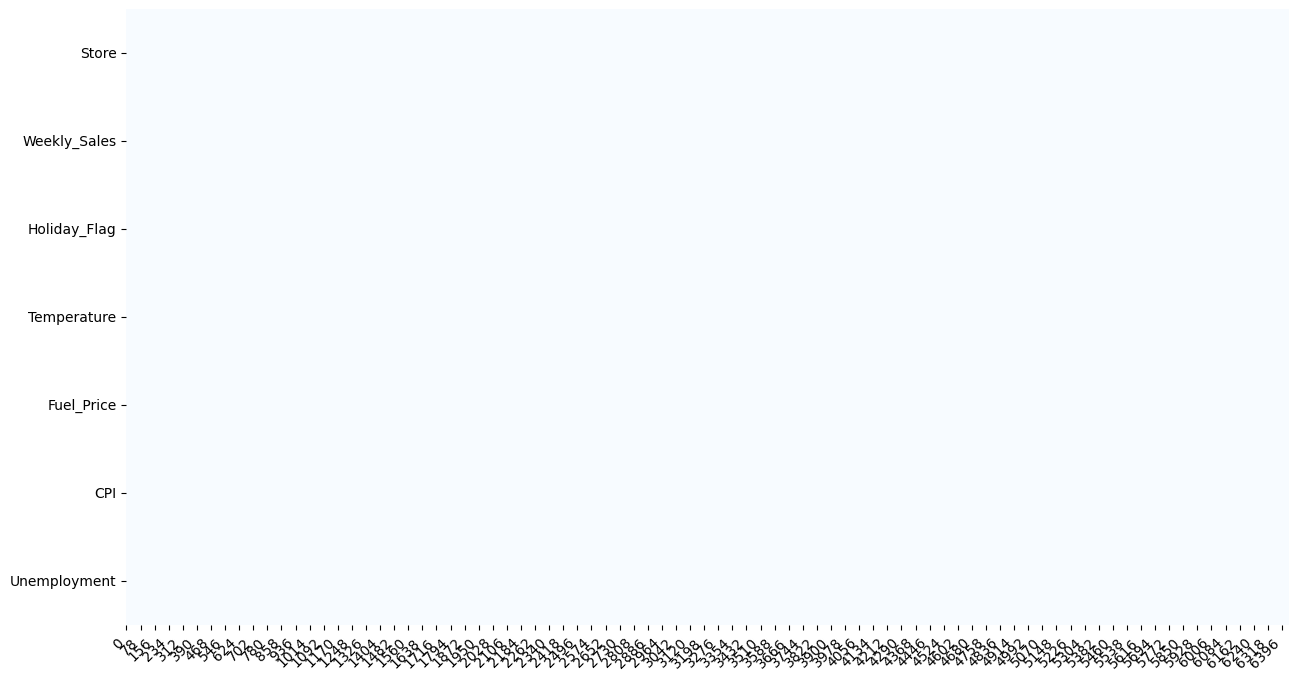

In [16]:
plot_missing_value(data, return_df=True)

#Dataset Splitting

In [17]:
X = data.drop(columns=['Holiday_Flag'])
y = data.Holiday_Flag

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5148, 6), (1287, 6), (5148,), (1287,))

#Training

In [18]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [19]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), X_train.columns)
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.4756699028339012, 'algo__gamma': 5, 'algo__learning_rate': 0.24258953709486805, 'algo__max_depth': 10, 'algo__n_estimators': 143, 'algo__reg_alpha': 0.009473317412345247, 'algo__reg_lambda': 0.004711553953121186, 'algo__subsample': 0.4093821097865351}
0.9759129759129759 0.9436674436674437 0.9526029526029526


#Feature Importance

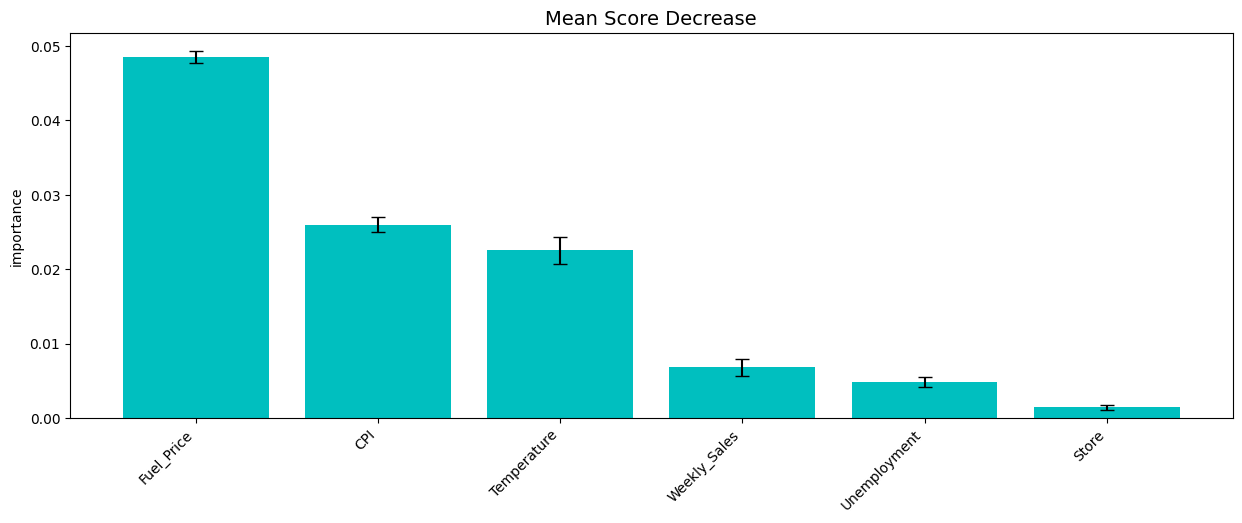

In [20]:
data_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk = 10)

In [21]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Fuel_Price', 'CPI', 'Temperature'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7419203085006956, 'algo__gamma': 1, 'algo__learning_rate': 0.27762530094438326, 'algo__max_depth': 7, 'algo__n_estimators': 113, 'algo__reg_alpha': 0.09444574254983565, 'algo__reg_lambda': 0.12329098365270522, 'algo__subsample': 0.5137705091792748}
0.9974747474747475 0.9658119658119658 0.9813519813519813


#Insights:
- Fuel_Price, CPI, and Temperature have very high impact on Holiday Flag.
